<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/utomoreza/assessment-mini-project/blob/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/utomoreza/assessment-mini-project/blob/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/utomoreza/assessment-mini-project/main/notebook/usecase-text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [2]:
!pip install -q tensorflow==2.15.1 portalocker==2.8.2 datasets==2.19.0 keras==2.15.0 tf-keras==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 42.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print("TF version:", tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [4]:
import os
import re
import pickle
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from datasets import load_dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
SEED = 1
FILE_PATH = "/content/sample_data/imdb"
TEST_SIZE = 0.4
BATCH_SIZE = 32
EPOCHS = 5
NUM_WORDS = 1000
OOV_TOKEN = "<UNK>"

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [6]:
def cleanse_text(dataset, stopwords_set):
    text = dataset["text"] # extract review text from "text" row

    text = text.lower() # set to lowercase

    # remove all non-word characters (everything except numbers and letters)
    text = re.sub(r"[^\w\s]", '', text)

    # remove digits
    text = re.sub(r"\d", '', text)

    # remove HTML tags
    text = re.sub(r"<.*?>", '', text)

    # remove URLs
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r"www\S+", '', text)

    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove unnecessary whitespaces
    text = re.sub(f" {2,}", '', text)

    # remove stopwords
    text_split = tuple(text.split())
    list_token = (token for token in text_split if token not in stopword_set)
    text = " ".join(list_token)

    return {"clean_text": text}


def tokenize(dataset, tokenizer):
    tokens = tokenizer.texts_to_sequences([dataset["clean_text"]])
    return {"tokens": tokens[0]}


def padding(dataset, pad_type, trunc_type, maxlen):
    # Pad the sequences
    padded_tokens = pad_sequences(
        [dataset["tokens"]], padding=pad_type,
        truncating=trunc_type, maxlen=maxlen
    )
    return {"ids": padded_tokens}


def find_optimum_maxlen(list_tokens, percentile=0.75):
    maxlen = np.quantile([len(ele) for ele in list_tokens], percentile)
    return int(maxlen)


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])


def prediction_reports(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0).squeeze(axis=-1)

    # create confusion matrix plot
    cm = confusion_matrix(y_test.numpy(), y_pred, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=["Negative", "Positive"])

    # create classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()

    disp.plot()
    plt.show()

    return cm, df


def predict(text, model, stopword_set, tokenizer, pad_type, trunc_type, maxlen):
    # preprocess
    dict_sample = {"text": text}
    dict_sample = cleanse_text(dict_sample, stopword_set)
    dict_sample = tokenize(dict_sample, tokenizer)
    dict_sample = padding(dict_sample, pad_type, trunc_type, maxlen)
    ids = dict_sample["ids"]
    ids = tf.convert_to_tensor(ids)

    # predict
    y_pred = 1 if model.predict(ids)[0] > 0.5 else 0

    return y_pred


def save_tokenizer_model(tokenizer, model, max_length, save_path):
    if not os.path.exists(save_path):
        # Create the directory
        os.makedirs(save_path)

    # save tokenizer
    with open(os.path.join(save_path, "tokenizer.pickle"), 'wb') as handle:
        pickle.dump((tokenizer, max_length), handle, protocol=pickle.HIGHEST_PROTOCOL)
    # save entire model
    model.save(os.path.join(save_path, "model.keras"))
    # model.export(os.path.join(save_path, "model"))
    print(f"Tokenizer and the entire model saved successfully in {save_path}")


def load_tokenizer_model(save_path):
    # load trained tokenizer
    with open(f"{save_path}/tokenizer.pickle", 'rb') as handle:
        trained_tokenizer, max_length = pickle.load(handle)
    # load trained model
    trained_model = tf.keras.models.load_model(f"{save_path}/model.keras")

    return trained_tokenizer, trained_model, max_length

# Data Collection

## Downloading dataset

In [79]:
train_data, valid_data = load_dataset("imdb", split=["train", "test"])

In [8]:
def show_label_proportions(dataset):
    list_label = dataset["label"]
    count_neg_label = sum((1 for label in list_label if label == 0))
    count_pos_label = sum((1 for label in list_label if label == 1))
    return {
        "positive": count_pos_label,
        "negative": count_neg_label,
        "pos_ratio": count_pos_label/(count_pos_label + count_neg_label),
        "neg_ratio": count_neg_label/(count_pos_label + count_neg_label),
    }

In [9]:
show_label_proportions(train_data)

{'positive': 12500, 'negative': 12500, 'pos_ratio': 0.5, 'neg_ratio': 0.5}

In [80]:
splitted_valid_data = valid_data.train_test_split(
    test_size=TEST_SIZE, shuffle=True,
    seed=SEED, stratify_by_column="label"
)
valid_data = splitted_valid_data["train"]
test_data = splitted_valid_data["test"]

## Export & import dataset

In [82]:
train_data.to_csv(f"{FILE_PATH}/train_set.csv")
valid_data.to_csv(f"{FILE_PATH}/valid_set.csv")
test_data.to_csv(f"{FILE_PATH}/test_set.csv")

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

12952795

In [ ]:
train_data = load_dataset("csv", data_files=f"{FILE_PATH}/train_set.csv")
valid_data = load_dataset("csv", data_files=f"{FILE_PATH}/valid_set.csv")
test_data = load_dataset("csv", data_files=f"{FILE_PATH}/test_set.csv")

# Preprocessing

For cleansing the text, take in a string of review, then performs the following:
<ol>
    <li>Remove HTML tag from review</li>
    <li>Remove URLs from review</li>
    <li>Make entire review lowercase</li>
    <li>Split the review in words</li>
    <li>Remove all punctuation</li>
    <li>Remove empty strings from review</li>
    <li>Remove all stopwords</li>
    <li>Returns a list of the cleaned review after joining them back to a sentence</il>
</ol>

In [11]:
stopword_set = set(stopwords.words("english"))

train_data = train_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)
valid_data = valid_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)
test_data = test_data.map(
    cleanse_text, fn_kwargs={"stopwords_set": stopword_set}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [12]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_data["clean_text"])

# Get our training data word index
word_index = tokenizer.word_index

In [13]:
## TOKENIZE DATA ###
train_data = train_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)
valid_data = valid_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
PAD_TYPE = "post"
TRUNC_TYPE = "post"

max_length = find_optimum_maxlen(train_data["tokens"], percentile=0.75)

## PAD TOKENS ###
train_data = train_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)
valid_data = valid_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)
test_data = test_data.map(
    padding, fn_kwargs={
        "pad_type": PAD_TYPE,
        "trunc_type": TRUNC_TYPE,
        "maxlen": max_length
    }
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
### CREATE DATALOADER ###
# convert to torch tensor
train_data = train_data.with_format(
    type="tf", columns=["ids", "label"]
)
valid_data = valid_data.with_format(
    type="tf", columns=["ids", "label"]
)
test_data = test_data.with_format(
    type="tf", columns=["ids", "label"]
)

In [16]:
## Squeeze tensor's shape
X_train = tf.squeeze(train_data["ids"], axis=[1])
y_train = train_data["label"]

X_valid = tf.squeeze(valid_data["ids"], axis=[1])
y_valid = valid_data["label"]

X_test = tf.squeeze(test_data["ids"], axis=[1])
y_test = test_data["label"]

# Modelling LSTM Architecture

## Training

In [71]:
model_lstm = tf.keras.Sequential(
    [
        tf.keras.layers.Input((None,)),
        tf.keras.layers.Embedding(
            input_dim=len(word_index),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

In [69]:
dot_img_file = "/content/model_lstm.png"

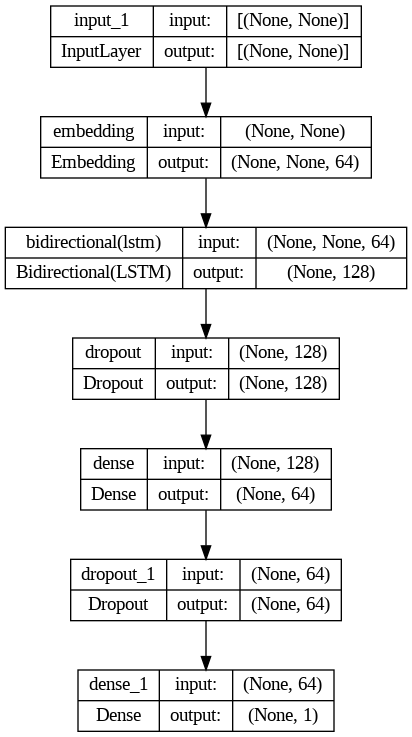

In [70]:
tf.keras.utils.plot_model(model_lstm, to_file=dot_img_file, show_shapes=True)

In [18]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          7535744   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [72]:
model_lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [73]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [74]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    callbacks=[callback]
)

Epoch 1/5
782/782 [==============================] - 241s 297ms/step - loss: 0.5977 - accuracy: 0.6689 - val_loss: 0.4344 - val_accuracy: 0.8187
Epoch 2/5
782/782 [==============================] - 220s 281ms/step - loss: 0.3952 - accuracy: 0.8357 - val_loss: 0.3692 - val_accuracy: 0.8387
Epoch 3/5
782/782 [==============================] - 218s 279ms/step - loss: 0.3563 - accuracy: 0.8490 - val_loss: 0.3704 - val_accuracy: 0.8341
Epoch 4/5
782/782 [==============================] - 218s 279ms/step - loss: 0.3421 - accuracy: 0.8567 - val_loss: 0.3506 - val_accuracy: 0.8437
Epoch 5/5
782/782 [==============================] - 218s 279ms/step - loss: 0.3349 - accuracy: 0.8565 - val_loss: 0.3552 - val_accuracy: 0.8429


## Evaluate

(0.0, 0.6169459447264671)

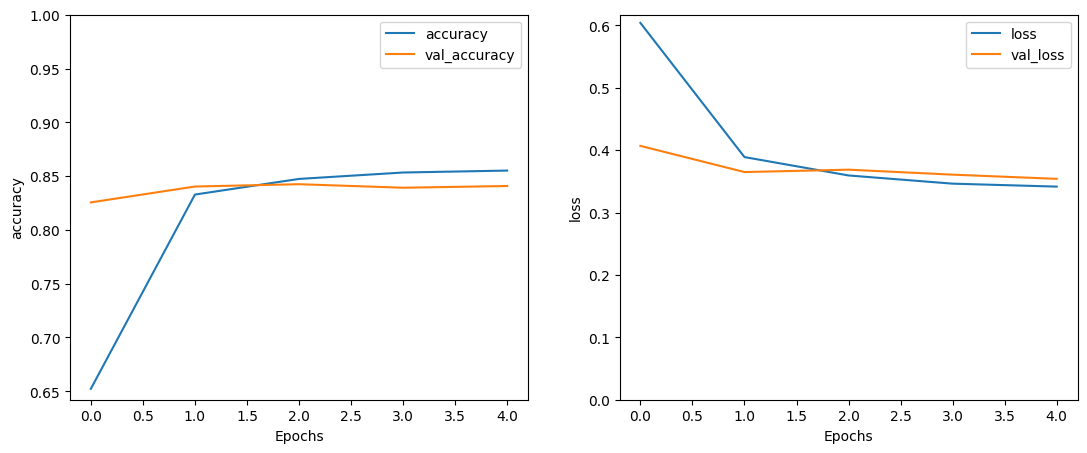

In [ ]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_lstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_lstm, 'loss')
plt.ylim(0, None)

In [ ]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.8370 - loss: 0.3553
Test Loss: 0.34571126103401184
Test Accuracy: 0.845447301864624


313/313 [==============================] - 14s 44ms/step


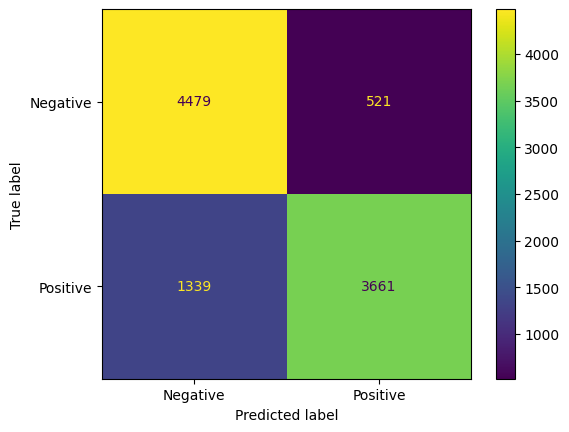

In [51]:
_, report_df = prediction_reports(model_lstm, X_test, y_test)

In [52]:
report_df

,precision,recall,f1-score,support
0,0.769852,0.8958,0.828064,5000.000
1,0.875418,0.7322,0.797430,5000.000
accuracy,0.814000,0.8140,0.814000,0.814
macro avg,0.822635,0.8140,0.812747,10000.000
weighted avg,0.822635,0.8140,0.812747,10000.000


## Predict random text

In [ ]:
text_predict = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
pred = predict(text_predict, model_lstm, stopword_set, tokenizer, PAD_TYPE, TRUNC_TYPE, max_length)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(f"Label: {pred} - Positive" if pred == 1 else f"Label: {pred} - Negative")

Label: 1 - Positive


## Saving Entire Model

In [24]:
def save_tokenizer_model(tokenizer, model, max_length, save_path):
    if not os.path.exists(save_path):
        # Create the directory
        os.makedirs(save_path)

    # save tokenizer
    with open(os.path.join(save_path, "tokenizer.pickle"), 'wb') as handle:
        pickle.dump((tokenizer, max_length), handle, protocol=pickle.HIGHEST_PROTOCOL)
    # save entire model
    model.save(os.path.join(save_path, "model.keras"))
    # model.export(os.path.join(save_path, "model"))
    print(f"Tokenizer and the entire model saved successfully in {save_path}")

In [25]:
save_tokenizer_model(tokenizer, model_lstm, max_length, "/content/model/usecase-text-lstm")

Tokenizer and the entire model saved successfully in /content/model/usecase-text-lstm


In [29]:
def load_tokenizer_model(save_path):
    # load trained tokenizer
    with open(f"{save_path}/tokenizer.pickle", 'rb') as handle:
        trained_tokenizer, max_length = pickle.load(handle)
    # load trained model
    trained_model = tf.keras.models.load_model(f"{save_path}/model.keras")

    return trained_tokenizer, trained_model, max_length

In [30]:
trained_tokenizer, trained_model_lstm, saved_max_length = load_tokenizer_model("/content/model/usecase-text-lstm")

# Modelling Transformer Architecture

## Training

In [57]:
@tf.keras.saving.register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

@tf.keras.saving.register_keras_serializable()
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [33]:
vocab_size = len(word_index)

In [75]:
inputs = tf.keras.layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_transformer = tf.keras.Model(inputs=inputs, outputs=outputs)

In [66]:
dot_img_file = "/content/model_transformer.png"

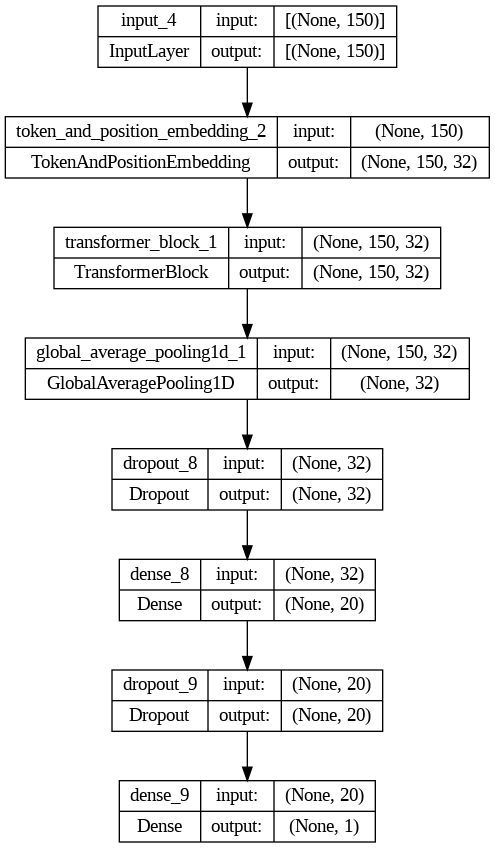

In [67]:
tf.keras.utils.plot_model(model_transformer, to_file=dot_img_file, show_shapes=True)

In [68]:
model_transformer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150)]             0         
                                                                 
 token_and_position_embeddi  (None, 150, 32)           3772672   
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (None, 150, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0   

In [76]:
model_transformer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [77]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [78]:
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    callbacks=[callback]
)

Epoch 1/5
782/782 [==============================] - 87s 105ms/step - loss: 0.6387 - accuracy: 0.6350 - val_loss: 0.5004 - val_accuracy: 0.8039
Epoch 2/5
782/782 [==============================] - 79s 100ms/step - loss: 0.4235 - accuracy: 0.8140 - val_loss: 0.3753 - val_accuracy: 0.8272
Epoch 3/5
782/782 [==============================] - 80s 102ms/step - loss: 0.3575 - accuracy: 0.8452 - val_loss: 0.3670 - val_accuracy: 0.8319
Epoch 4/5
782/782 [==============================] - 77s 98ms/step - loss: 0.3441 - accuracy: 0.8548 - val_loss: 0.3519 - val_accuracy: 0.8398
Epoch 5/5
782/782 [==============================] - 76s 97ms/step - loss: 0.3400 - accuracy: 0.8552 - val_loss: 0.3671 - val_accuracy: 0.8371


## Evaluation

(0.0, 0.6388878285884857)

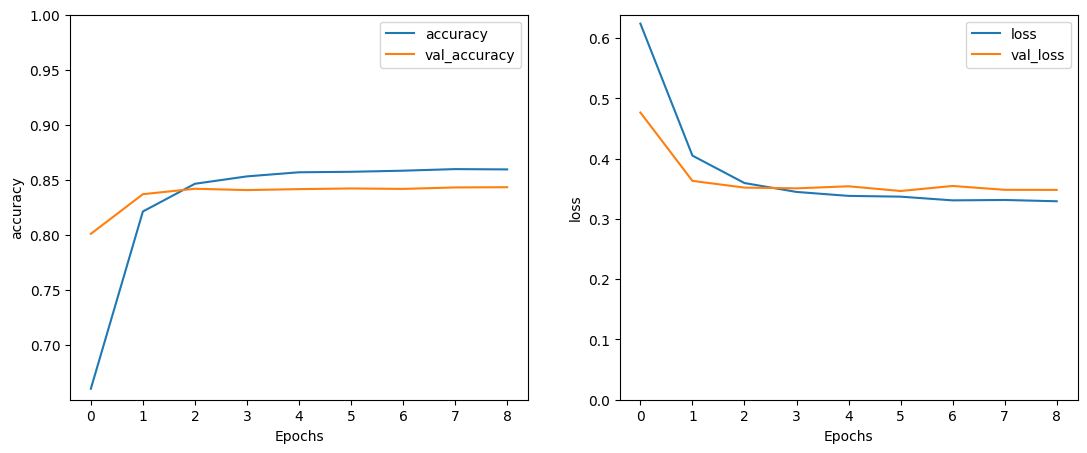

In [43]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_transformer, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_transformer, 'loss')
plt.ylim(0, None)

In [44]:
test_loss, test_acc = model_transformer.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

313/313 [==============================] - 6s 21ms/step - loss: 0.3396 - accuracy: 0.8493
Test Loss: 0.33960697054862976
Test Accuracy: 0.8493000268936157


313/313 [==============================] - 7s 21ms/step


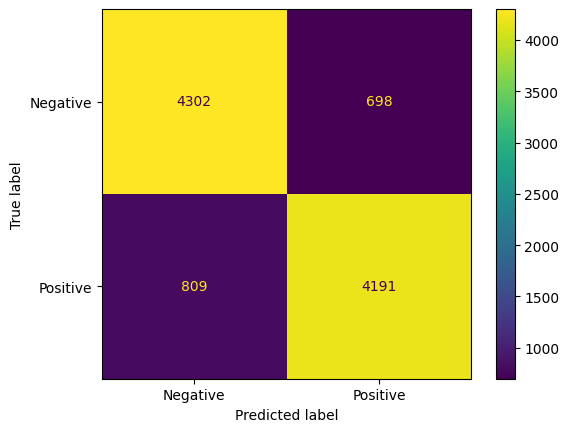

In [47]:
_, report_df = prediction_reports(model_transformer, X_test, y_test)

In [49]:
report_df

,precision,recall,f1-score,support
0,0.841714,0.8604,0.850954,5000.0000
1,0.857231,0.8382,0.847608,5000.0000
accuracy,0.849300,0.8493,0.849300,0.8493
macro avg,0.849472,0.8493,0.849281,10000.0000
weighted avg,0.849472,0.8493,0.849281,10000.0000


from matplotlib import pyplot as plt
_df_0['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
text_predict = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
pred = predict(text_predict, model_transformer, stopword_set, tokenizer, PAD_TYPE, TRUNC_TYPE, max_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


In [ ]:
print(f"Label: {pred} - Positive" if pred == 1 else f"Label: {pred} - Negative")

Label: 1 - Positive


## Saving Entire Model

In [63]:
save_tokenizer_model(tokenizer, model_transformer, max_length, "/content/model/usecase-text-transformer")

Tokenizer and the entire model saved successfully in /content/model/usecase-text-transformer


In [64]:
trained_tokenizer, trained_model_transformer, saved_max_length = load_tokenizer_model("/content/model/usecase-text-transformer")